### Какую задачу решаю:
Смотрю все 2к-квартиры в продаже по москве, <b>анализирую, рассчитываю прогнозную цену квартиры</b>, нахожу тех у кого цена более занижена, относительно прогнозной, считаю что она более потенциальна для покупки, и такие квартиры уже изучаю более детально
### Последовательность действий:
<ul><li> Спарсить на Авито все двушки по Москве - их цену будем оценивать
    <li> Спарсить на Яндекс.Недвижимость по адресам из объявлений характеристики домов,  а также историю объявлений по данным адресам
        <ol><li> Характеристики домов, для увеличения точности предсказания стоимости
            <li> История цен в старых объявлениях: Для дополнительной проверки нашей модели, в сравнении с моделью яндекса 
        </ol>
</ul> 
<b>Эти шаги остались за кадром.</b>

### Здесь рассмотрим:
<ol><li> <b>Загрузка данных и предварительная обработка.</b> Так как некоторые данные достал довольно сырыми (чтобы парсер не делать долго, хотя все равно времени потратилось больше ожидаемого), их перед тем как анализировать - надо обработать: выделить столбцы нужные из текста, что-то преобразовать и уже после этого анализировать
    <li> Анализ и дополинтельная подготовка данных для модели
    <li> Построение модели предсказания стоимости и оценка качества
    <li> Просмотр объявлений, которые сильно выбиваются из модели (это уже здесь показывать не буду, посмотрю сам) :)
    <li> Размышления на тему, что можно улучшить
</ol>

In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Загрузка данных и обработка 

In [200]:
data_flats= pd.read_csv('2020_09_12_avito_moskva.csv',sep=';',index_col=0)#,error_bad_lines=False)
data_adr= pd.read_csv('yandex_info.csv',sep=';',index_col=0)

In [201]:
data_flats.head()

,0,1,2,3,4,5
0,13700000,"\n 2-к квартира, 65 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...,"\n Лукинская ул., 10\n",Новопеределкино,"1,3 км"
1,7912000,"\n 2-к квартира, 43 м², 2/5 эт.\n",/moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...,"\n 12-я Парковая ул., 5\n",Первомайская,900 м
2,9390000,"\n 2-к квартира, 52.2 м², 4/17 эт.\n",/moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...,"\n Покровская ул., 17к2\n",Некрасовка,600 м
3,8667975,"\n 2-к квартира, 59.3 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...,"\n Рождественская ул., 33\n",Некрасовка,200 м
4,9180000,"\n 2-к квартира, 58.9 м², 13/17 эт.\n",/moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...,"\n ул. Лавриненко, 1\n",Некрасовка,800 м


In [202]:
data_adr.head()

,ADR,AVG_PRICE,STANDARD_DEVIATION,COEF_OF_VARIATION,AVG_PRICE_>_0,year_house,house_info
0,"\n Лукинская ул., 10\n",182450.975,22329.321700,0.122385,True,Дом 2010 года,25 этажейМонолитное зданиеЦентральное отоплени...
1,"\n 12-я Парковая ул., 5\n",197831.250,49847.736218,0.251971,True,Дом 1952 года,"5 этажейКирпично-монолитное здание3,50 м потол..."
2,"\n Покровская ул., 17к2\n",140767.275,28461.645652,0.202189,True,Дом 2017 года,"17 этажейПанельное здание2,75 м потолки160 ква..."
3,"\n Рождественская ул., 33\n",152670.850,19756.900085,0.129408,True,Дом,"Панельное зданиеЦентральное отопление2,70 м по..."
4,"\n ул. Лавриненко, 1\n",128101.300,16427.625946,0.128239,True,Дом,"17 этажей2,80 м потолкиЛифтМусоропровод"


Видим выше, что данные по среднему прайсу довольно странные, видимо где-то была допущена ошибка при расчете)) Сейчас уже переделывать не буду, так как парсинг 5к объявлений занимает около 3 часов. Удалим эти столбцы и объединим две таблицы в одну

### Обработка данных
<ol><li>Удалим лишние столбцы
    <li>Избавимся от непонятных знаков
        <li> Разделим столбцы, которые содержат несколько характеристик на несколько столбцов
    <ol>

In [203]:
add_cols=pd.DataFrame() #Сюда будем добавлять обработанные столбцы чтобы их потом добавить в итоговый датафрейм
data=data_flats.join(data_adr)
data=data.drop(['3','AVG_PRICE','STANDARD_DEVIATION','COEF_OF_VARIATION'], axis=1) # удалили нейдачный этап по определению средней цены из обявлений яндекса архивных
data.head(3)

,0,1,2,4,5,ADR,AVG_PRICE_>_0,year_house,house_info
0,13700000,"\n 2-к квартира, 65 м², 13/25 эт.\n",/moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...,Новопеределкино,"1,3 км","\n Лукинская ул., 10\n",True,Дом 2010 года,25 этажейМонолитное зданиеЦентральное отоплени...
1,7912000,"\n 2-к квартира, 43 м², 2/5 эт.\n",/moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...,Первомайская,900 м,"\n 12-я Парковая ул., 5\n",True,Дом 1952 года,"5 этажейКирпично-монолитное здание3,50 м потол..."
2,9390000,"\n 2-к квартира, 52.2 м², 4/17 эт.\n",/moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...,Некрасовка,600 м,"\n Покровская ул., 17к2\n",True,Дом 2017 года,"17 этажейПанельное здание2,75 м потолки160 ква..."


Преобразовываем поля и разбиваем на доп столбцы. Информацию о доме вытащил из яндекса, ее также буду разбивать на столбцы 

In [204]:
# \n 2-к квартира, 65 м², 13/25 эт.\n переводим в плоащдь этаж квартиры и этаж дома
temp1=data['1'].replace('\n', '', regex=True).str.split(',',expand=True)#[2].value_counts()[120:150]
add_cols['square']=temp1[1].replace(' м²', '', regex=True).astype(float)
add_cols['floor']=temp1[2].str.split('/',expand=True)[0].astype(int)
add_cols['house_floor']=temp1[2].str.split('/',expand=True).replace(' эт.', '', regex=True).astype(int)[1]
#1,3 км переводим в расстояние в метрах до метро
temp1=data['5'].replace(' ', '').replace(',', '.', regex=True).str.split('\xa0',expand=True)
def rule(x, y):
    if y == 'м' :  return float(x)
    elif y == 'км': return float(x)*1000
    else: return 0
add_cols['dist_metro']=temp1.apply(lambda x: rule(x[0], x[1]), axis =  1)
#Дом 2010 года переводим в 2010 (год постройки дома)
add_cols['year_house_draft']=data['year_house'].str.split(' ',expand=True)[1]
#Разделяем на столбцы 25\xa0этажейМонолитное зданиеЦентральное отопление2,50\xa0м потолки480\xa0квартирГаза нетЛифтМусоропровод'
add_cols['Musor']=data['house_info'].str.split('Мусоропров',expand=True)[1].replace('ода нет', 0, regex=True).replace('од', 1, regex=True)
add_cols['Lift']=data['house_info'].str.split('Мусоропров',expand=True)[0].str.split('Лиф',expand=True)[1].replace('т отсутствует', 0, regex=True).replace('т', 1, regex=True)
add_cols['Gas']=data['house_info'].str.split('Мусоропров',expand=True)[0].str.split('Лиф',expand=True)[0].\
str.split('Га',expand=True)[1].replace('за нет', 0, regex=True).replace('з', 1, regex=True)
temp1=data['house_info'].str.split('Мусоропров',expand=True)[0].str.split('Лиф',expand=True)[0].\
str.split('Га',expand=True)[0]
add_cols['Flats_in_house']=temp1.str.split('олки',expand=True)[1].str.split('\xa0',expand=True)[0]
add_cols['floors_height']=temp1.str.split('олки',expand=True)[0].str.rsplit('ние',n=1, expand=True)[1].replace(',', '.', regex=True).str.split('\xa0',expand=True)[0]
add_cols['Central_heating']=temp1.str.split('олки',expand=True)[0].str.rsplit('ние',n=1, expand=True)[0].str.split('зда',expand=True)[1]\
.replace('ниеЦентральное отопле', 1, regex=True).replace('', 0, regex=True)
#для поиска типа дома использовал функцию, так как вариант со сплитом имеет погрешность из раза в раз 
def tip_zdania(x):
    if x.find('Панельное')>=0 : return 'Панельное'
    elif x.find('Кирпичное')>=0: return 'Кирпичное'
    elif x.find('Монолитное')>=0: return 'Монолитное'
    elif x.find('Блочное')>=0: return 'Блочное'
    elif x.find('Кирпично-монолитное')>=0: return 'Кирпично-монолитное'
    elif x.find('Кирпичное')>=0: return 'Кирпичное'
    else: return 0
add_cols['tip_zdania']=data['house_info'].apply(lambda x: tip_zdania(str(x)))    
add_cols['renovaciya']=data['house_info'].str.find('Дом входит в программу сноса')#0 для реновации
add_cols['floors_house']=temp1.str.split('олки',expand=True)[0].str.rsplit('ние',n=1, expand=True)[0].str.split('зда',expand=True)[0]\
.replace('этажей', 'этаж', regex=True).replace('этажа', 'этаж', regex=True)\
.replace('Дом входит в программу сноса пятиэтажек в Москве, подробнее.', '', regex=True)\
.str.split('этаж',expand=True)[0].str.split('\n',n=1,expand=True)[0].replace('Панельное', '', regex=True)\
.replace('Монолитное', '', regex=True)

In [205]:
full_data=add_cols.join(data[['0','2','4','ADR','AVG_PRICE_>_0']])\
.rename(columns={'0':"target",'2':'link','4':'metro','ADR':'Adress','AVG_PRICE_>_0':'found_in_yandex'})
full_data.head()

,square,floor,house_floor,dist_metro,year_house_draft,Musor,Lift,Gas,Flats_in_house,floors_height,Central_heating,tip_zdania,renovaciya,floors_house,target,link,metro,Adress,found_in_yandex
0,65.0,13,25,1300.0,2010,1.0,1.0,0.0,480,2.50,1,Монолитное,-1.0,25,13700000,/moskva/kvartiry/2-k_kvartira_65_m_1325_et._19...,Новопеределкино,"\n Лукинская ул., 10\n",True
1,43.0,2,5,900.0,1952,NaN,1.0,NaN,,3.50,0,Кирпично-монолитное,-1.0,5,7912000,/moskva/kvartiry/2-k_kvartira_43_m_25_et._1425...,Первомайская,"\n 12-я Парковая ул., 5\n",True
2,52.2,4,17,600.0,2017,1.0,1.0,0.0,160,2.75,0,Панельное,-1.0,17,9390000,/moskva/kvartiry/2-k_kvartira_52.2_m_417_et._2...,Некрасовка,"\n Покровская ул., 17к2\n",True
3,59.3,13,25,200.0,None,1.0,1.0,0.0,768,2.70,1,Панельное,-1.0,,8667975,/moskva/kvartiry/2-k_kvartira_59.3_m_1325_et._...,Некрасовка,"\n Рождественская ул., 33\n",True
4,58.9,13,17,800.0,None,1.0,1.0,NaN,,None,None,0,-1.0,17,9180000,/moskva/kvartiry/2-k_kvartira_58.9_m_1317_et._...,Некрасовка,"\n ул. Лавриненко, 1\n",True


Уберем данные по объявлениям у которых домов не нашлось в яндексе и тем где нет метро проставленного. Потому что хочу рассматривать только тех у кого есть метро, и тех чей дом определен. Заведомо отсечем странные объявления.

In [206]:
print('Всего объявлений: ',len(full_data),'\nНе найдено на маркете: ',len(full_data)-sum(full_data.found_in_yandex),'\nНет метро: ',sum(full_data.metro.isnull()))

Всего объявлений:  4293 
Не найдено на маркете:  565 
Нет метро:  13


In [207]:
full_data=full_data[(full_data.found_in_yandex==1)&(full_data.metro.notnull())]
full_data.describe()

,square,floor,house_floor,dist_metro,Musor,Lift,Gas,renovaciya,target
count,3718.000000,3718.000000,3718.000000,3718.000000,3582.000000,3646.000000,3064.000000,3694.000000,3.718000e+03
mean,51.162587,6.605433,12.818720,1060.839161,0.829146,0.833516,0.515013,-0.939361,1.018365e+07
std,13.092539,5.060149,6.189106,784.123840,0.376434,0.372565,0.499856,0.238699,2.251202e+06
min,25.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.600000e+06
25%,44.500000,3.000000,9.000000,600.000000,1.000000,1.000000,0.000000,-1.000000,8.500000e+06
50%,51.000000,5.000000,12.000000,900.000000,1.000000,1.000000,1.000000,-1.000000,9.800000e+06
75%,56.000000,9.000000,17.000000,1300.000000,1.000000,1.000000,1.000000,-1.000000,1.190000e+07
max,532.000000,35.000000,53.000000,4800.000000,1.000000,1.000000,1.000000,0.000000,1.500000e+07


Получили итоговый датасет, который будем анализировать

# 2. Анализ датасета

Разбираемся с типами и заполняем пустые значения предполгаемыми по умолчанию. Для этого посмотрим кол-во пустых значений

In [208]:
full_data.isnull().sum()

square                0
floor                 0
house_floor           0
dist_metro            0
year_house_draft    161
Musor               136
Lift                 72
Gas                 654
Flats_in_house      850
floors_height        97
Central_heating     114
tip_zdania            0
renovaciya           24
floors_house         24
target                0
link                  0
metro                 0
Adress                0
found_in_yandex       0
dtype: int64

### 1. Заменим нулевыми значениями np.nan, переведем во float и заполним получившиеся пустоты средними либо наиболее вероятными, логически, значениями

In [209]:
#Для высоты потолка взял медианное значение, в этом поле возможно косяк
import warnings
warnings.filterwarnings('ignore')
full_data.fillna({'Musor':1, 'Lift':1,'year_house_draft':np.nan,'Flats_in_house':np.nan,'floors_height':np.nan\
                  ,'renovaciya':np.nan,'Gas':np.nan,'floors_house':np.nan,'Central_heating':np.nan}, inplace=True)
full_data.Flats_in_house[full_data.Flats_in_house=='']=np.nan
full_data.floors_height[full_data.floors_height=='']=np.nan
full_data.renovaciya[full_data.renovaciya=='']=np.nan
full_data.Gas[full_data.Gas=='']=np.nan
full_data.floors_house[full_data.floors_house=='']=np.nan
full_data.floors_house[full_data.floors_house==' ']=np.nan
#Избавляемся от редко встречающихся слов
full_data.floors_house = np.where(full_data.floors_house.isin(full_data.floors_house.value_counts().index[full_data.floors_house.value_counts() < 10]), np.nan, full_data.floors_house)
full_data.fillna({'year_house_draft':full_data.year_house_draft.astype(float).median(),'Flats_in_house':full_data.Flats_in_house.astype(float).median(),'floors_height':full_data.floors_height.astype(float).median()\
                  ,'renovaciya':-1,'Gas':1,'floors_house':full_data.floors_house.astype(float).median(),'Central_heating':full_data.Central_heating.astype(float).median()}, inplace=True)
full_data.Flats_in_house=full_data.Flats_in_house.astype(int)
full_data.floors_height=full_data.floors_height.astype(float)
full_data.tip_zdania=full_data.tip_zdania.astype(str)
full_data.floors_house=full_data.floors_house.astype(int)
full_data.year_house_draft=full_data.year_house_draft.astype(int)
#tip_zdania
#floors_house

In [210]:
full_data.dtypes

square              float64
floor                 int64
house_floor           int64
dist_metro          float64
year_house_draft      int64
Musor               float64
Lift                float64
Gas                 float64
Flats_in_house        int64
floors_height       float64
Central_heating     float64
tip_zdania           object
renovaciya          float64
floors_house          int64
target                int64
link                 object
metro                object
Adress               object
found_in_yandex        bool
dtype: object

### 2. Перед анализом давайте попробуем бейзлайн собрать:

In [211]:
cat_columns = full_data.select_dtypes(include='object').columns
target=full_data.target
full_data_base=full_data.drop(columns='target')
num_columns = full_data_base.select_dtypes(exclude='object').columns
print('Нечисленные колонки:',cat_columns,'\nЧисленные колонки: ',num_columns)

Нечисленные колонки: Index(['tip_zdania', 'link', 'metro', 'Adress'], dtype='object') 
Численные колонки:  Index(['square', 'floor', 'house_floor', 'dist_metro', 'year_house_draft',
       'Musor', 'Lift', 'Gas', 'Flats_in_house', 'floors_height',
       'Central_heating', 'renovaciya', 'floors_house', 'found_in_yandex'],
      dtype='object')


In [212]:
train_X, test_X, train_y, test_y = train_test_split(full_data_base[num_columns], target, random_state=1)
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
linear_val_predictions = linear_model.predict(test_X)
linear_val_mae = mean_absolute_error(linear_val_predictions, test_y)
print("MAE Линейной регрессии Бейз: {:,.0f}".format(linear_val_mae))

MAE Линейной регрессии Бейз: 1,670,824


In [213]:
list(test_y[0:5]), list(linear_val_predictions[0:5])

([11000000, 14200000, 5399000, 12000000, 8800000],
 [10345030.141492497,
  10809320.71586031,
  9643981.62132417,
  10797621.04408531,
  10866311.784907656])

Прогнозные значения меняются слабо, не смотря на то, что таргет пргыает сильно.Да и средняя ошибка в 1.7 млн уж очень большая Будем смотреть данные

### 3. Посмотрим на значения:

#### Численные поля

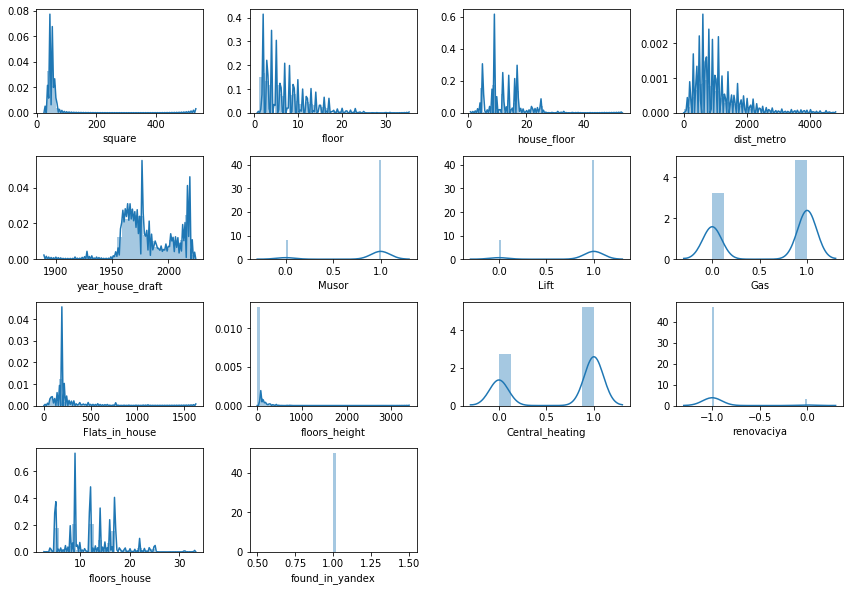

In [214]:
#.select_dtypes(exclude='object').copy()

fig = plt.figure(figsize=(12,18))
for i in range(len(num_columns)):
    fig.add_subplot(9,4,i+1)
    sns.distplot(full_data[num_columns].iloc[:,i].dropna(),kde_kws={'bw': 0.1})
    plt.xlabel(num_columns[i])

plt.tight_layout()
plt.show()

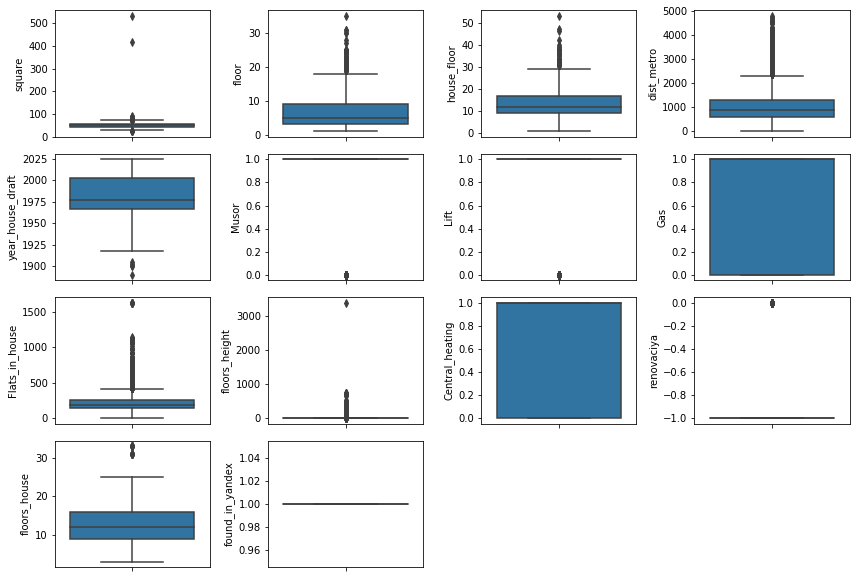

In [215]:
fig = plt.figure(figsize=(12, 18))

for i in range(len(num_columns)):
    fig.add_subplot(9, 4, i+1)
    sns.boxplot(y=full_data[num_columns].iloc[:,i])

plt.tight_layout()
plt.show()

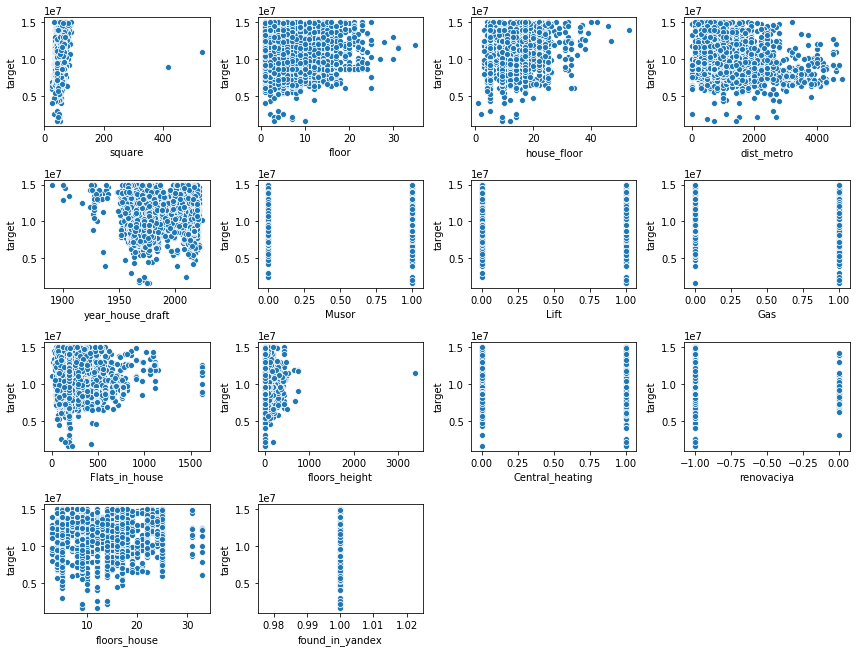

In [216]:
f = plt.figure(figsize=(12,20))

for i in range(len(num_columns)):
    f.add_subplot(9, 4, i+1)
    sns.scatterplot(full_data[num_columns].iloc[:,i], full_data.target)
    
plt.tight_layout()
plt.show()

Поля, которые необходимо поправить:
* <b>square</b> - избавиться от двух значений выше 300
* <b>year_house_draft</b> - меньше 1925 года не считаем
* <b>floors_height</b> - плохой парсинг.Все что больше 4. Удалять такое большое кол-во строк нельзя - можем заменить на 2.7 везде
* <b>found_in_yandex</b> - нужно убрать. Мы уже выбрали всех у кого это поле единица (тех, чьи адреса смогли найти на яндекс недвижимость)
* <b>target</b> - нужно убрать квартиры стоимостью менее 4млн (либо обмен, либо рента, либо обман)

In [217]:
full_data.loc[full_data.square>300, 'square']=full_data.loc[full_data.square>300, 'square']/10# обычные квартиры, только потерялась запятая. Поделим на 10
full_data.loc[full_data.year_house_draft<1950,'year_house_draft']=1950#49 квартир меньше 1950 года. Им всем припишем 1950 (год постройки значимое полеи чем на меньшую дистанцию размазываем тем лучше)
full_data.loc[full_data.floors_height>=4,'floors_height']=2.7
full_data.loc[full_data.floors_height<=2,'floors_height']=2.7 #Также выбиваются две точки 1 и 2 их тоже изменю
full_data=full_data.loc[full_data.target>=4000000]#['link'])

Посмотрим корреляцию между численными полями

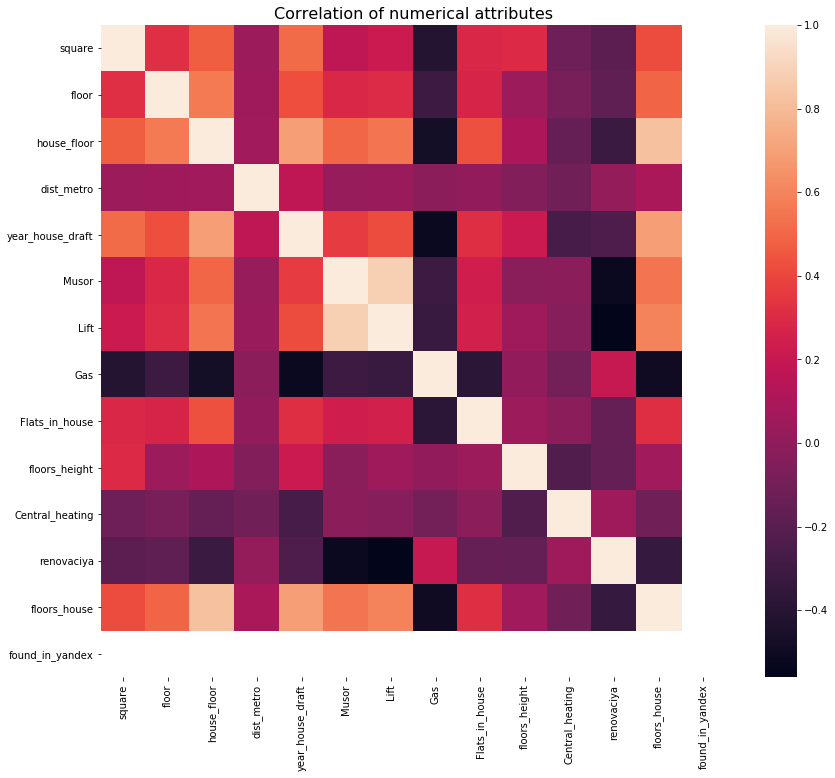

In [221]:
correlation = full_data[num_columns].corr()

f, ax = plt.subplots(figsize=(14,12))
plt.title('Correlation of numerical attributes', size=16)
sns.heatmap(correlation)
plt.show()

In [222]:
correlation 

,square,floor,house_floor,dist_metro,year_house_draft,Musor,Lift,Gas,Flats_in_house,floors_height,Central_heating,renovaciya,floors_house,found_in_yandex
square,1.000000,0.322586,0.474557,0.046865,0.515052,0.176374,0.216109,-0.411867,0.290869,0.293500,-0.121236,-0.186373,0.420303,NaN
floor,0.322586,1.000000,0.564869,0.057769,0.426852,0.290389,0.303450,-0.314507,0.271241,0.046207,-0.080980,-0.176252,0.488091,NaN
house_floor,0.474557,0.564869,1.000000,0.064608,0.690183,0.498356,0.543135,-0.479036,0.431414,0.104339,-0.149271,-0.320351,0.824559,NaN
dist_metro,0.046865,0.057769,0.064608,1.000000,0.175094,0.027298,0.042568,-0.015994,0.010336,-0.046052,-0.111700,0.019564,0.102419,NaN
year_house_draft,0.515052,0.426852,0.690183,0.175094,1.000000,0.364144,0.420338,-0.519976,0.311690,0.216289,-0.265499,-0.243322,0.694966,NaN
Musor,0.176374,0.290389,0.498356,0.027298,0.364144,1.000000,0.878947,-0.310581,0.241057,-0.018869,-0.005905,-0.515006,0.547581,NaN
Lift,0.216109,0.303450,0.543135,0.042568,0.420338,0.878947,1.000000,-0.323522,0.251161,0.052321,-0.035541,-0.560612,0.591665,NaN
Gas,-0.411867,-0.314507,-0.479036,-0.015994,-0.519976,-0.310581,-0.323522,1.000000,-0.380939,0.006560,-0.102954,0.202044,-0.493807,NaN
Flats_in_house,0.290869,0.271241,0.431414,0.010336,0.311690,0.241057,0.251161,-0.380939,1.000000,0.046081,-0.014513,-0.147021,0.316644,NaN
floors_height,0.293500,0.046207,0.104339,-0.046052,0.216289,-0.018869,0.052321,0.006560,0.046081,1.000000,-0.233095,-0.154051,0.062640,NaN


* Очень высока корреляция наличия Лифта и наличия мусоропровода (0,87) - объяснимо, мусоропровод в высоких домах чаще есть, а там и лифт также присутствует - Исключаем Мусор
* Высока корреляция floors_house и house_floor - это фактически одно и то же поле - этажность дома. Первое значение из объявления авито, второе из яндекса инфа о доме. Исключаем яндексовскую (floors_house - там было очень много пропущенных данных) 

#### Нечисленные поля

In [223]:
cat_columns

Index(['tip_zdania', 'link', 'metro', 'Adress'], dtype='object')

Ссылку и адрес изучать нет смысла, а вот тип здания и метро можно посмотреть

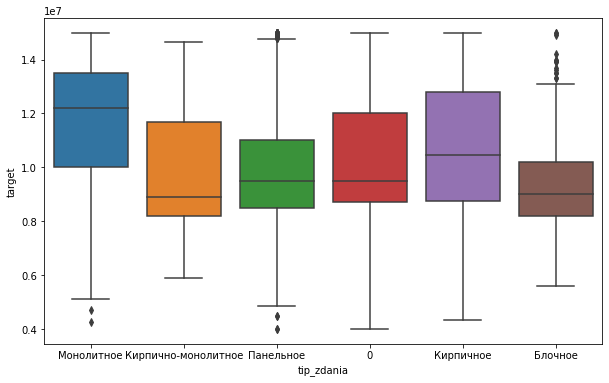

In [224]:
var = full_data['tip_zdania']
f, ax = plt.subplots(figsize=(10,6))
sns.boxplot(y=full_data.target, x=var)
plt.show()

Монолитные и кирпичные здания лучше ценятся, чем панельные. Для кирпично-монолитного - возможно старый дома входят и выборка малая

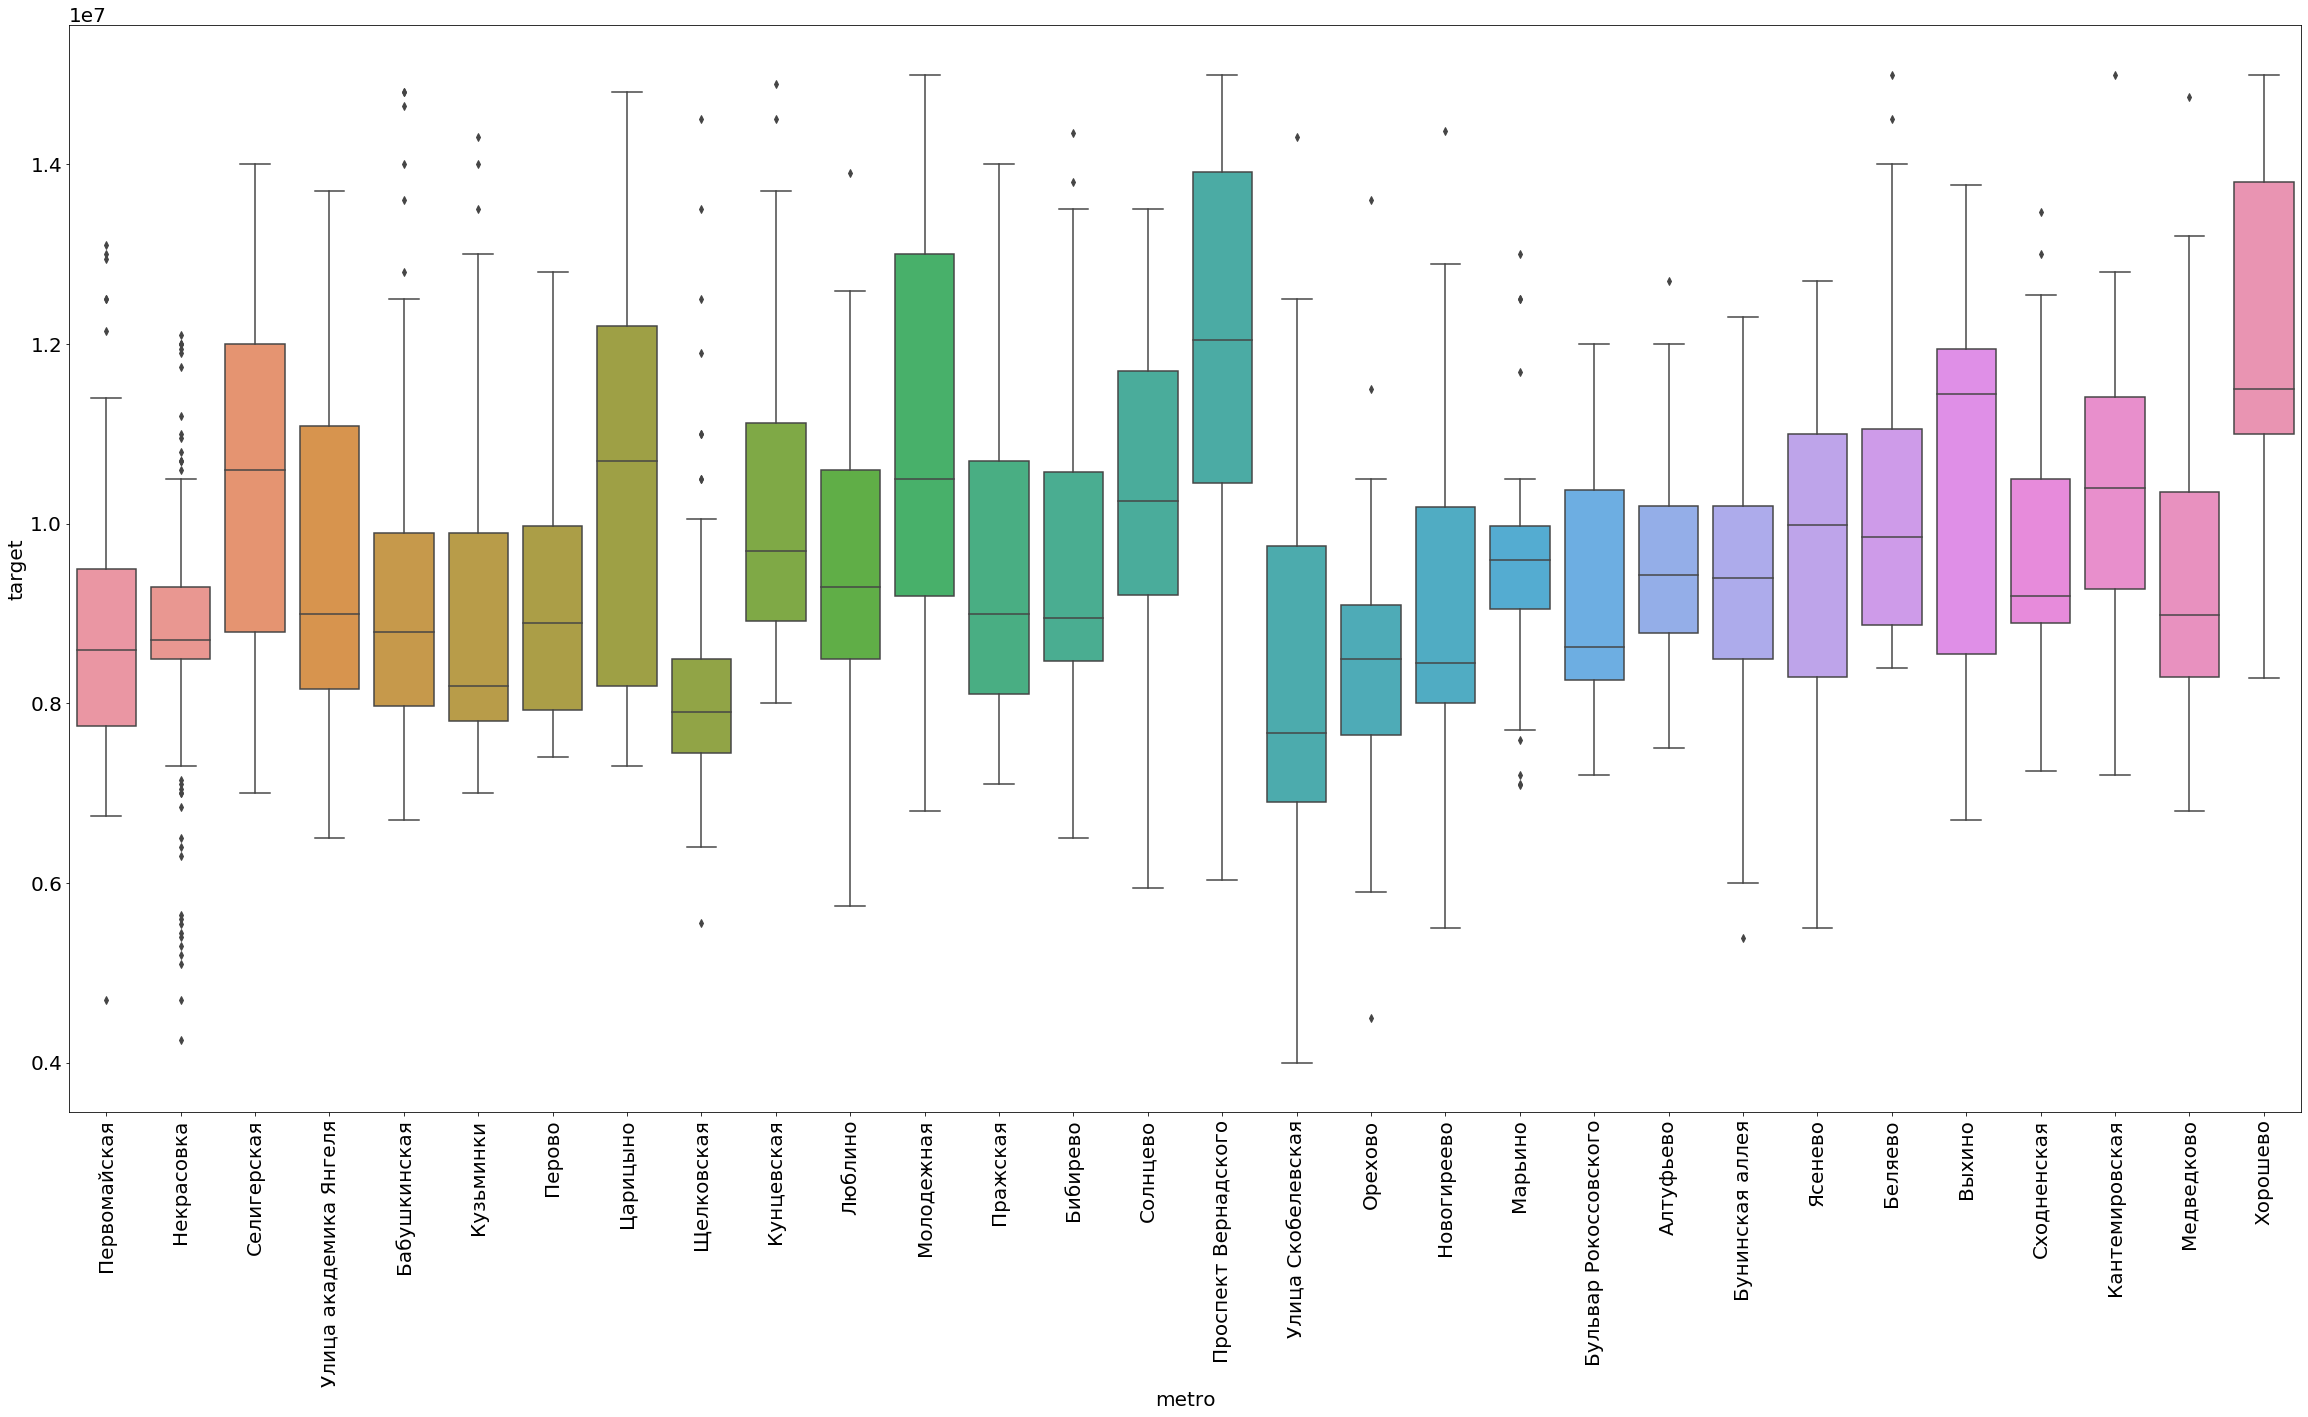

In [228]:
#Топ 30 самых популярных станций метро
f, ax = plt.subplots(figsize=(40,20))
sns.boxplot(y=full_data[full_data.metro.isin(list(full_data.metro.value_counts().head(30).index))].target, x=full_data[full_data.metro.isin(list(full_data.metro.value_counts().head(30).index))].metro)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.show()

Видим что самые низкие цены на скобелевской, а высокие на Хорошево, Молодежной, пр. Вернадского. Но нужно учитывать, что при парсинге я ограничивался верхней суммой в 15 млн рублей

### 4. Улучшим бейзлайн

In [230]:
cat_columns = full_data.select_dtypes(include='object').columns
target=full_data.target
full_data_base1=full_data.drop(columns=['target','found_in_yandex','Musor','floors_house'])
num_columns = full_data_base1.select_dtypes(exclude='object').columns
print('Нечисленные колонки:',cat_columns,'\nЧисленные колонки: ',num_columns)

Нечисленные колонки: Index(['tip_zdania', 'link', 'metro', 'Adress'], dtype='object') 
Численные колонки:  Index(['square', 'floor', 'house_floor', 'dist_metro', 'year_house_draft',
       'Lift', 'Gas', 'Flats_in_house', 'floors_height', 'Central_heating',
       'renovaciya'],
      dtype='object')


In [232]:
train_X, test_X, train_y, test_y = train_test_split(full_data_base1[num_columns], target, random_state=1)
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
linear_val_predictions = linear_model.predict(test_X)
linear_val_mae = mean_absolute_error(linear_val_predictions, test_y)
print("MAE Линейной регрессии Бейз1: {:,.0f}".format(linear_val_mae))

MAE Линейной регрессии Бейз1: 1,495,794


Результат улучшился (была погрешность 1.7, теперь 1.5 млн). Давайте чтобы one hot encoding не делать - попробуем катбуст и посмотрим насолько уменбшится погрешность:

In [236]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=10)
model.fit(train_X, train_y)
# Get predictions
preds = model.predict(test_X)
catboost_mae = mean_absolute_error(preds, test_y)
print("MAE CatBoost численные: {:,.0f}".format(catboost_mae))

Learning rate set to 0.5
0:	learn: 1964420.5523158	total: 6.79ms	remaining: 61.1ms
1:	learn: 1845125.0385894	total: 10.1ms	remaining: 40.3ms
2:	learn: 1794703.1860321	total: 11.8ms	remaining: 27.5ms
3:	learn: 1749325.0879484	total: 14.8ms	remaining: 22.2ms
4:	learn: 1702274.6424414	total: 15.9ms	remaining: 15.9ms
5:	learn: 1676525.1316831	total: 17ms	remaining: 11.3ms
6:	learn: 1646966.6058738	total: 18.3ms	remaining: 7.83ms
7:	learn: 1628197.0491517	total: 20ms	remaining: 5ms
8:	learn: 1616700.2148853	total: 22.3ms	remaining: 2.47ms
9:	learn: 1607199.3056177	total: 24.1ms	remaining: 0us
MAE CatBoost численные: 1,342,058


In [259]:
cols_cat=list(num_columns)#list(num_columns).append(['metro','tip_zdania'])
cols_cat.append('metro')
cols_cat.append('tip_zdania')
train_X, test_X, train_y, test_y = train_test_split(full_data_base1[cols_cat], target, random_state=1)
model.fit(train_X, train_y,cat_features=['metro','tip_zdania'])
# Get predictions
preds = model.predict(test_X)
catboost_mae = mean_absolute_error(preds, test_y)
print("MAE CatBoost численные: {:,.0f}".format(catboost_mae))

Learning rate set to 0.5
0:	learn: 1942801.2701530	total: 7.59ms	remaining: 68.3ms
1:	learn: 1790034.8160844	total: 10.6ms	remaining: 42.4ms
2:	learn: 1649751.7135363	total: 13.8ms	remaining: 32.2ms
3:	learn: 1563172.8824173	total: 16.6ms	remaining: 25ms
4:	learn: 1525834.4869642	total: 19.6ms	remaining: 19.6ms
5:	learn: 1505474.7569268	total: 22.3ms	remaining: 14.9ms
6:	learn: 1483499.6674716	total: 25.1ms	remaining: 10.8ms
7:	learn: 1470394.4218729	total: 28.4ms	remaining: 7.11ms
8:	learn: 1456214.5580520	total: 32.2ms	remaining: 3.58ms
9:	learn: 1441308.2482064	total: 34.2ms	remaining: 0us
MAE CatBoost численные: 1,134,614


Среднее абсолютное отклоенение уменьшилось с 1,5 до 1,1 млн. что уже неплохой результат

Будущие улучшения (перенести в конец файла):
    1. Более тщательно парсить - чтобы сразу каждое поле в нужную колонку попадало.
    2. При необходимости разбивки больших текстовых полей split replace делать более аккуратно, сейчас много неточностей
    3. Текст также можно спарсить и возможно через tf-idf что то интересное можно поймать
    4. Добавить признак частное объявление или нет
    5. Дата публикации (в идеале отслеживать с даты создания объявления) - тоже связь может быть
    7. Признак снижения цены
    8. Поиграться с фолдами и прокачкой характеристик модели, проверить на переобучаемость, в случае чего провести регуляризацию, 
    9. насытить другой информацией о домах (есть сайты где указано когда был последний капремонт и прочее)
    10. И убрать оганичение в 15 млн.